##Import the libraries

In [1]:
# 1. Install packages not included in standard Colab
# !pip install -q kaggle lime shap scikit-image

# 2. Standard Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# 3. Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split , cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score ,classification_report , confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE


# 4. Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor

# 5. Explainable AI (XAI) & Inspection
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
!pip install -q kaggle lime shap scikit-image
import lime
from lime import lime_tabular, lime_image, lime_text
from sklearn.utils import resample # Needed for ICE sampling

# 6. Text & Image Specific
from sklearn.feature_extraction.text import TfidfVectorizer
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

# 7. Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

from glob import glob
from tqdm import tqdm
from scipy.sparse import hstack

print("Libraries loaded successfully!")

# 1. Install the Kaggle library
!pip install -q kaggle

# 2. Upload your kaggle.json file
# ACTION REQUIRED: Run this cell, click "Choose Files", and select your kaggle.json file.
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

# 3. Move the file to the correct directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API setup complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Libraries loaded successfully!
Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API setup complete!


#Dataset 1 : Airline Passenger Satisfaction

In [2]:
print("\nDownloading Dataset 1 :")
!mkdir -p dataset_1
!kaggle datasets download -d teejmahal20/airline-passenger-satisfaction -p dataset_1


Dataset URL: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction
License(s): other
  0% 0.00/2.71M [00:00<?, ?B/s]
100% 2.71M/2.71M [00:00<00:00, 578MB/s]


In [3]:
!unzip -q dataset_1/airline-passenger-satisfaction.zip -d dataset_1
!rm dataset_1/airline-passenger-satisfaction.zip
print("Dataset 1 ready in folder: dataset_1/")

Dataset 1 ready in folder: dataset_1/


## Analyze dataset

In [4]:
df = pd.read_csv('dataset_1/train.csv')

In [5]:
df.shape

(103904, 25)

In [6]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [7]:
df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols

Index(['Unnamed: 0', 'id', 'Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')

In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction'], dtype='object')

In [12]:
df[numeric_cols].describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [13]:
df[categorical_cols].describe()

,Gender,Customer Type,Type of Travel,Class,satisfaction
count,103904,103904,103904,103904,103904
unique,2,2,2,3,2
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,52727,84923,71655,49665,58879


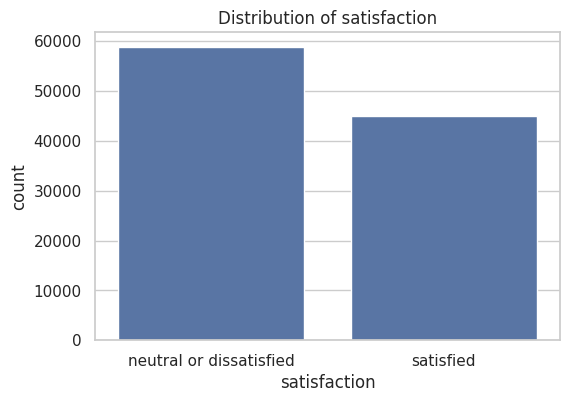

In [14]:
# 7️⃣ Distribution of target variable
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='satisfaction')
plt.title('Distribution of satisfaction')
plt.show()

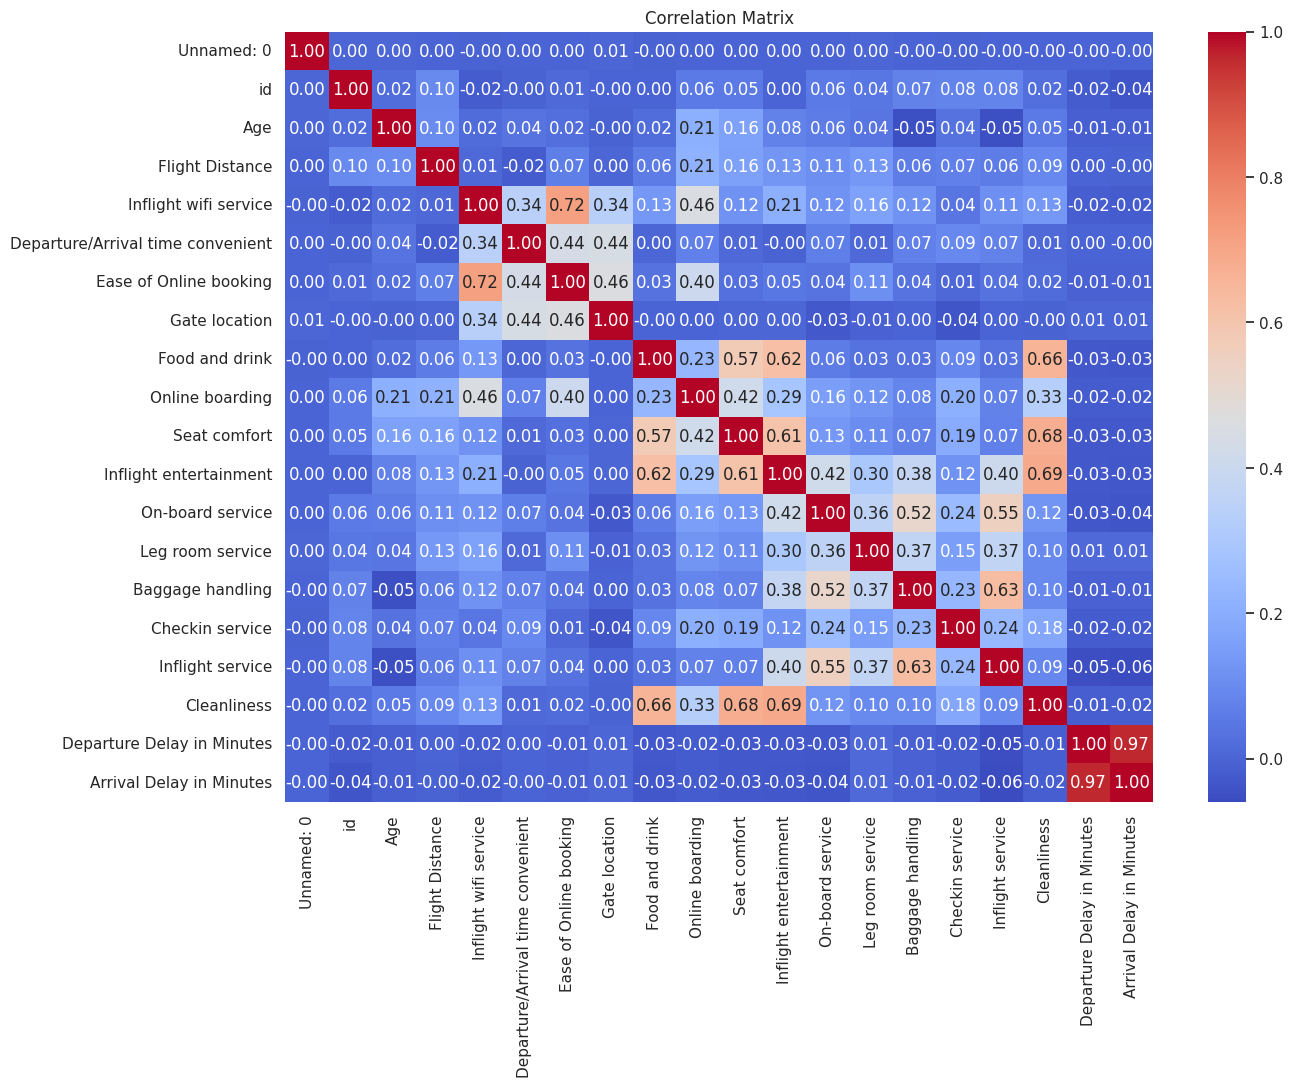

In [15]:
# 2. Convert 'Satisfaction' to numeric (if it's text)
# Adjust the mapping {'satisfied': 1, 'neutral or dissatisfied': 0} based on your actual data values
if 'Satisfaction' in df.columns and df['Satisfaction'].dtype == 'object':
    df['Satisfaction_Binary'] = df['Satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})

# 3. Calculate Correlations (Numeric columns only)
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# 4. Plot Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

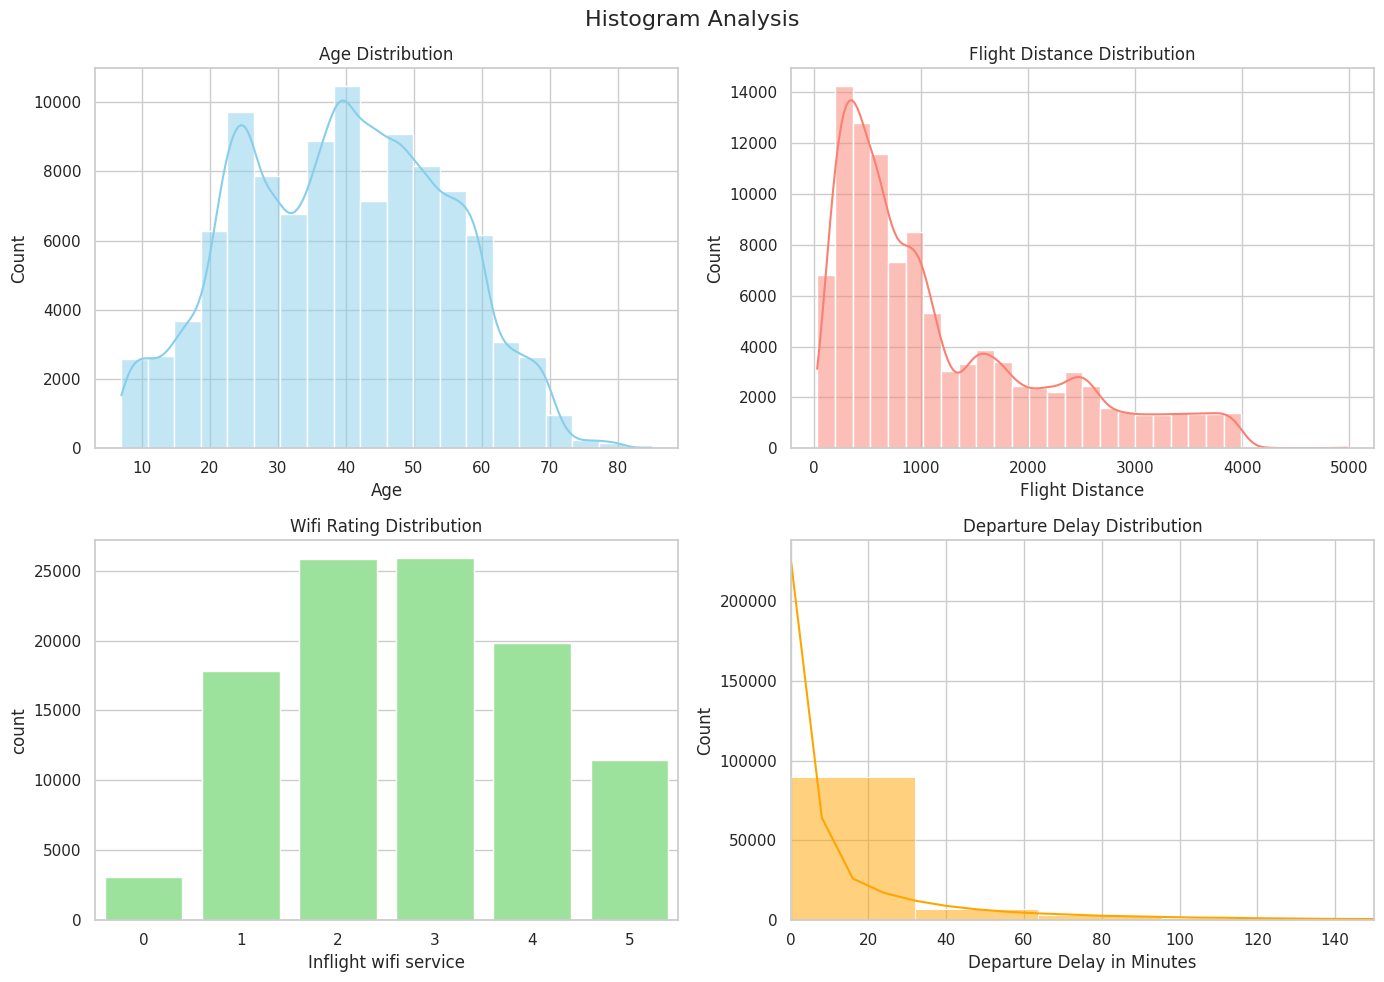

In [16]:
# 2. Setup the figure size
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Histogram Analysis', fontsize=16)

# 3. Plot Histograms
# Change 'Age', 'Flight Distance', etc. to match your exact column names

# Age
sns.histplot(data=df, x='Age', kde=True, bins=20, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')

# Flight Distance
sns.histplot(data=df, x='Flight Distance', kde=True, bins=30, color='salmon', ax=axes[0, 1])
axes[0, 1].set_title('Flight Distance Distribution')

# Wifi Service (Categorical/Ordinal)
sns.countplot(data=df, x='Inflight wifi service', color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title('Wifi Rating Distribution')

# Departure Delay (limit x-axis to see better if data is skewed)
sns.histplot(data=df, x='Departure Delay in Minutes', kde=True, bins=50, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Departure Delay Distribution')
axes[1, 1].set_xlim(0, 150) # Optional: zoom in on 0-150 minutes

plt.tight_layout()
plt.show()

##Feature engineering

In [17]:
cols_to_drop = ['id', 'Unnamed: 0']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Impute missing 'Arrival Delay'
# Strategy: If Arrival Delay is missing, assume it's similar to Departure Delay or 0
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Departure Delay in Minutes'])

In [18]:
# A. Create "Total Delay"
# Instead of two separate correlated columns, combine them to capture the total time lost.
df['Total_Delay'] = df['Departure Delay in Minutes'] + df['Arrival Delay in Minutes']

# B. Log Transformation for Skewed Data
# Your histogram showed Delays are highly right-skewed. Log transform helps normalize this.
# We add +1 to avoid log(0) errors.
df['Total_Delay_Log'] = np.log1p(df['Total_Delay'])

# C. Binning Flight Distance (Optional but helpful for some models)
# Categorize into Short, Medium, Long Haul
df['Flight_Range'] = pd.cut(df['Flight Distance'],
                            bins=[0, 1500, 3000, 10000],
                            labels=['Short', 'Medium', 'Long'])

In [19]:
# List of columns containing service ratings (0-5)
service_cols = ['Inflight wifi service', 'Departure/Arrival time convenient',
                'Ease of Online booking', 'Gate location', 'Food and drink',
                'Online boarding', 'Seat comfort', 'Inflight entertainment',
                'On-board service', 'Leg room service', 'Baggage handling',
                'Checkin service', 'Inflight service', 'Cleanliness']

# Create an "Overall Experience Score"
# Averaging these gives a single metric for "Luxury/Comfort" level
df['Average_Service_Rating'] = df[service_cols].mean(axis=1)

In [20]:
# A. Label Encoding for Target Variable
le = LabelEncoder()
df['satisfaction'] = le.fit_transform(df['satisfaction'])
# 0 = neutral or dissatisfied, 1 = satisfied (usually)

# B. One-Hot Encoding for Nominal Variables
# Columns: Gender, Customer Type, Type of Travel, Class, Flight_Range (created above)
categorical_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Flight_Range']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

In [21]:
scaler = StandardScaler()
continuous_cols = ['Age', 'Flight Distance', 'Total_Delay', 'Average_Service_Rating']

df_encoded[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])

# Final Check
print("New Data Shape:", df_encoded.shape)

New Data Shape: (103904, 29)


In [22]:
df_encoded.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Total_Delay,Total_Delay_Log,Average_Service_Rating,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,Flight_Range_Medium,Flight_Range_Long
0,-1.745279,-0.731539,3,4,3,1,5,3,5,5,...,0.169413,3.784190,0.931392,True,False,True,False,True,False,False
1,-0.951360,-0.957184,3,2,3,3,1,3,1,1,...,-0.301931,2.079442,-1.442994,True,True,False,False,False,False,False
2,-0.885200,-0.047584,2,2,2,2,5,5,5,5,...,-0.393581,0.000000,0.715538,False,False,False,False,False,False,False
3,-0.951360,-0.629246,2,5,5,5,2,2,2,2,...,-0.131723,3.044522,-0.363728,False,False,False,False,False,False,False
4,1.430397,-0.978244,3,3,3,3,4,5,5,3,...,-0.393581,0.000000,0.391759,True,False,False,False,False,False,False


## Train and evaluate for the model.

In [23]:
# Define Features (X) and Target (y)
# 'satisfaction' is our target (0 or 1 from LabelEncoder)
X = df_encoded.drop('satisfaction', axis=1)
y = df_encoded['satisfaction']

# Split into Train (80%) and Test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (83123, 28)
Testing set shape: (20781, 28)


In [24]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Multi-Layer Perceptron (MLP)": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

In [25]:
results = {}
print("\n--- Model Training Log ---")

for name, model in models.items():
    print(f"Training {name}...")
    # A. Train the model
    model.fit(X_train, y_train)
    # B. Make predictions
    y_pred = model.predict(X_test)
    # C. Calculate Accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"--> {name} Accuracy: {acc:.4f}")

    # Optional: Print detailed report for the best performers (usually RF or GB)
    if name in ["Random Forest", "Gradient Boosting"]:
        print(classification_report(y_test, y_pred))
        print("-" * 30)


--- Model Training Log ---
Training Random Forest...
--> Random Forest Accuracy: 0.9603
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     11713
           1       0.97      0.94      0.95      9068

    accuracy                           0.96     20781
   macro avg       0.96      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781

------------------------------
Training Gradient Boosting...
--> Gradient Boosting Accuracy: 0.9415
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11713
           1       0.95      0.92      0.93      9068

    accuracy                           0.94     20781
   macro avg       0.94      0.94      0.94     20781
weighted avg       0.94      0.94      0.94     20781

------------------------------
Training Multi-Layer Perceptron (MLP)...
--> Multi-Layer Perceptron (MLP) Accuracy: 0.9502


In [26]:
# Print summary table
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\nFinal Leaderboard:")
print(results_df)


Final Leaderboard:
                          Model  Accuracy
0                 Random Forest  0.960252
2  Multi-Layer Perceptron (MLP)  0.950243
1             Gradient Boosting  0.941533


##Apply the XAI

Computing Permutation Feature Importance...


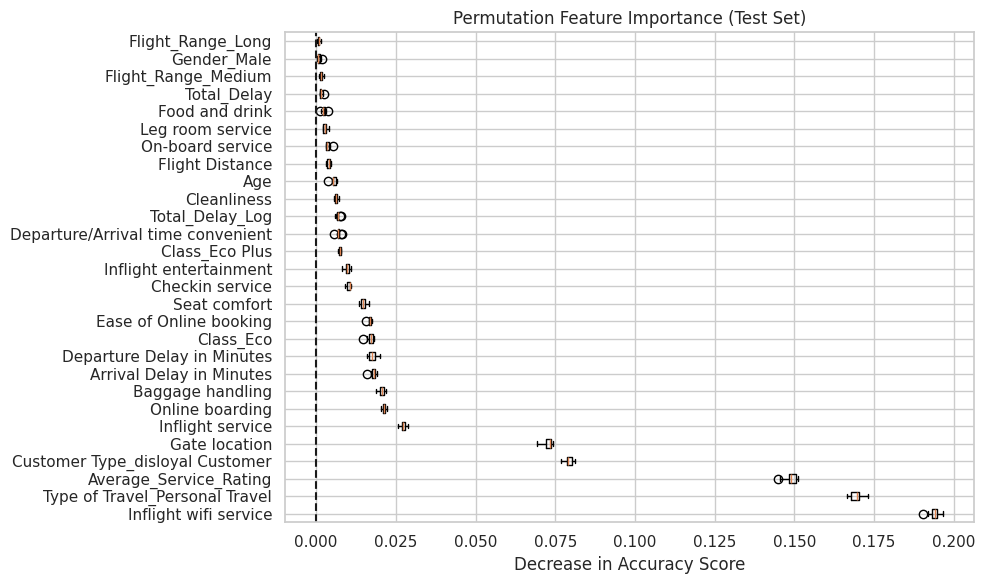

In [27]:
print("Computing Permutation Feature Importance...")
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()[::-1]

# Plot Top 10 Features
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Feature Importance (Test Set)")
plt.axvline(x=0, color="k", linestyle="--")
plt.xlabel("Decrease in Accuracy Score")
plt.tight_layout()
plt.show()

In [107]:
print(model)

GradientBoostingClassifier(random_state=42)


Generating LIME explanation...
Explaining Passenger #10 | True Label: 1


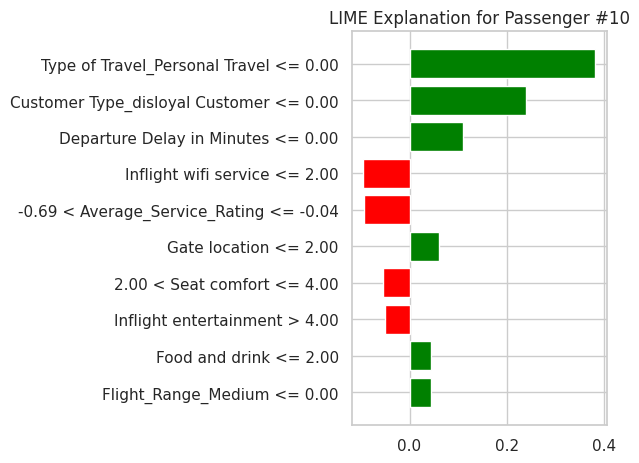

In [28]:
print("Generating LIME explanation...")

# Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Neutral/Dissatisfied', 'Satisfied'],
    mode='classification'
)

# Pick a random passenger from the test set to explain (e.g., index 10)
idx = 10
passenger_data = X_test.iloc[idx]
true_label = y_test.iloc[idx]

print(f"Explaining Passenger #{idx} | True Label: {true_label}")

# Generate explanation
exp = explainer.explain_instance(
    data_row=passenger_data,
    predict_fn=model.predict_proba
)

# Visualize
exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Passenger #{idx}")
plt.tight_layout()
plt.show()

Generating PDP for: Average_Service_Rating...


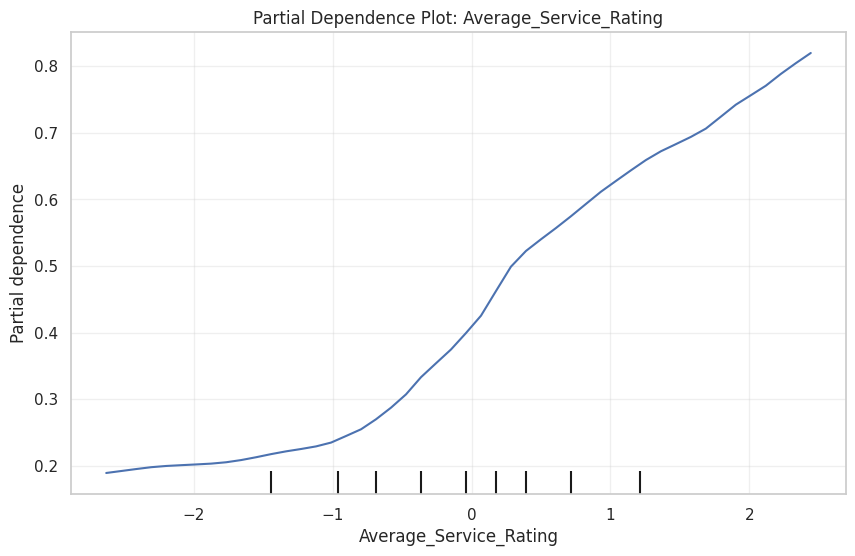

In [29]:
target_feature = 'Average_Service_Rating'

print(f"Generating PDP for: {target_feature}...")

# 2. Create the Plot
fig, ax = plt.subplots(figsize=(10, 6))

# We use a sample of 500 points to make it run fast and avoid memory errors
X_sample = X_test.sample(n=500, random_state=42)

display = PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_sample,
    features=[target_feature],
    kind='average', # <--- 'average' = PDP Only (No error-prone ICE lines)
    ax=ax
)

plt.title(f"Partial Dependence Plot: {target_feature}")
plt.grid(True, alpha=0.3)
plt.show()

Generating ICE Plot for: Age...


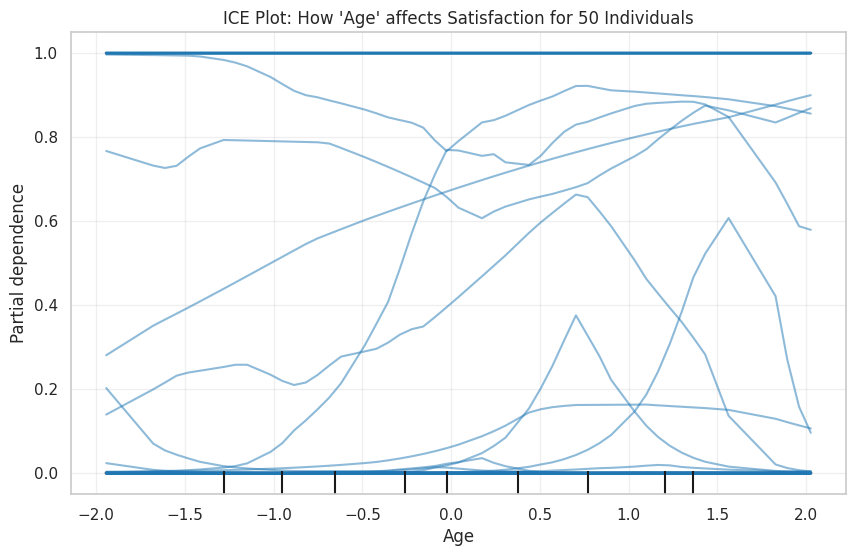

In [30]:
target_feature = 'Age'

print(f"Generating ICE Plot for: {target_feature}...")

# 2. Sample the data
# We only plot 50 random passengers to keep the visualization clean
X_sample = X_test.sample(n=100, random_state=42)

fig, ax = plt.subplots(figsize=(10, 6))

# 3. Generate ICE Plot
display = PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X_sample,
    features=[target_feature],
    kind='individual',  # <--- 'individual' = ICE Only
    ax=ax
)

# 4. Styling for better visibility
# Access the lines to make them thinner and semi-transparent
for lines in display.lines_[0, 0]:
    lines.set_alpha(0.5)
    lines.set_linewidth(1.5)
    lines.set_color('#1f77b4') # Standard Matplotlib Blue

plt.title(f"ICE Plot: How '{target_feature}' affects Satisfaction for 50 Individuals")
plt.grid(True, alpha=0.3)
plt.show()

#Dataste 2 : California Housing Prices

In [31]:
print("\nDownloading Dataset 2 :")
!mkdir -p dataset_2
!kaggle datasets download -d camnugent/california-housing-prices -p dataset_2


Dataset URL: https://www.kaggle.com/datasets/camnugent/california-housing-prices
License(s): CC0-1.0
  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 1.02GB/s]


In [32]:
!unzip -q dataset_2/california-housing-prices.zip -d dataset_2
!rm dataset_2/california-housing-prices.zip
print("Dataset 2 ready in folder: dataset_2/")

Dataset 2 ready in folder: dataset_2/


## Analyze dataset

In [33]:
df = pd.read_csv('dataset_2/housing.csv')

In [34]:
df.shape

(20640, 10)

In [35]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [36]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [38]:
df.duplicated().sum()

np.int64(0)

In [39]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [40]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['ocean_proximity'], dtype='object')

In [41]:
df[numeric_cols].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [42]:
df[categorical_cols].describe()

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


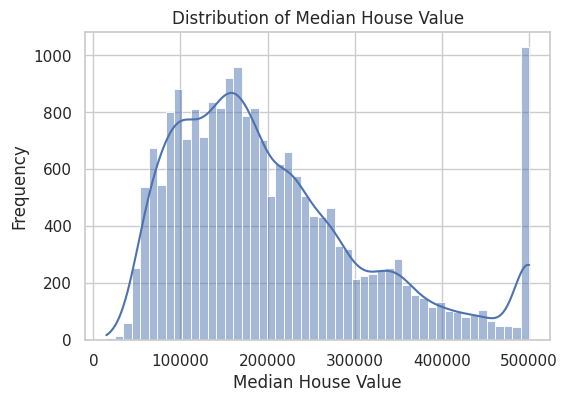

In [43]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='median_house_value', kde=True, bins=50)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

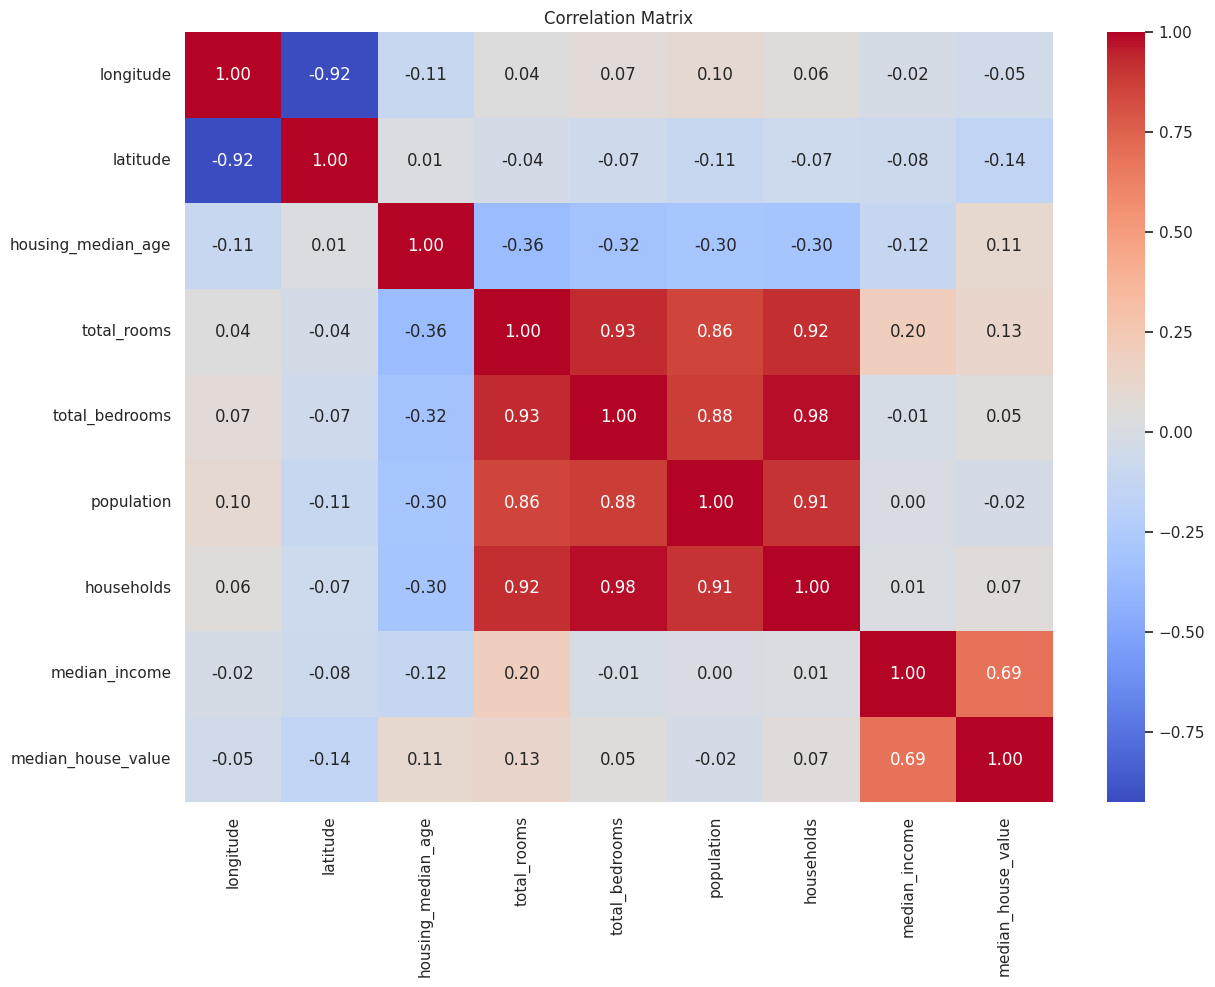

In [44]:
# 2. Convert 'Satisfaction' to numeric (if it's text)
# Adjust the mapping {'satisfied': 1, 'neutral or dissatisfied': 0} based on your actual data values
if 'Satisfaction' in df.columns and df['Satisfaction'].dtype == 'object':
    df['Satisfaction_Binary'] = df['Satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})

# 3. Calculate Correlations (Numeric columns only)
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# 4. Plot Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

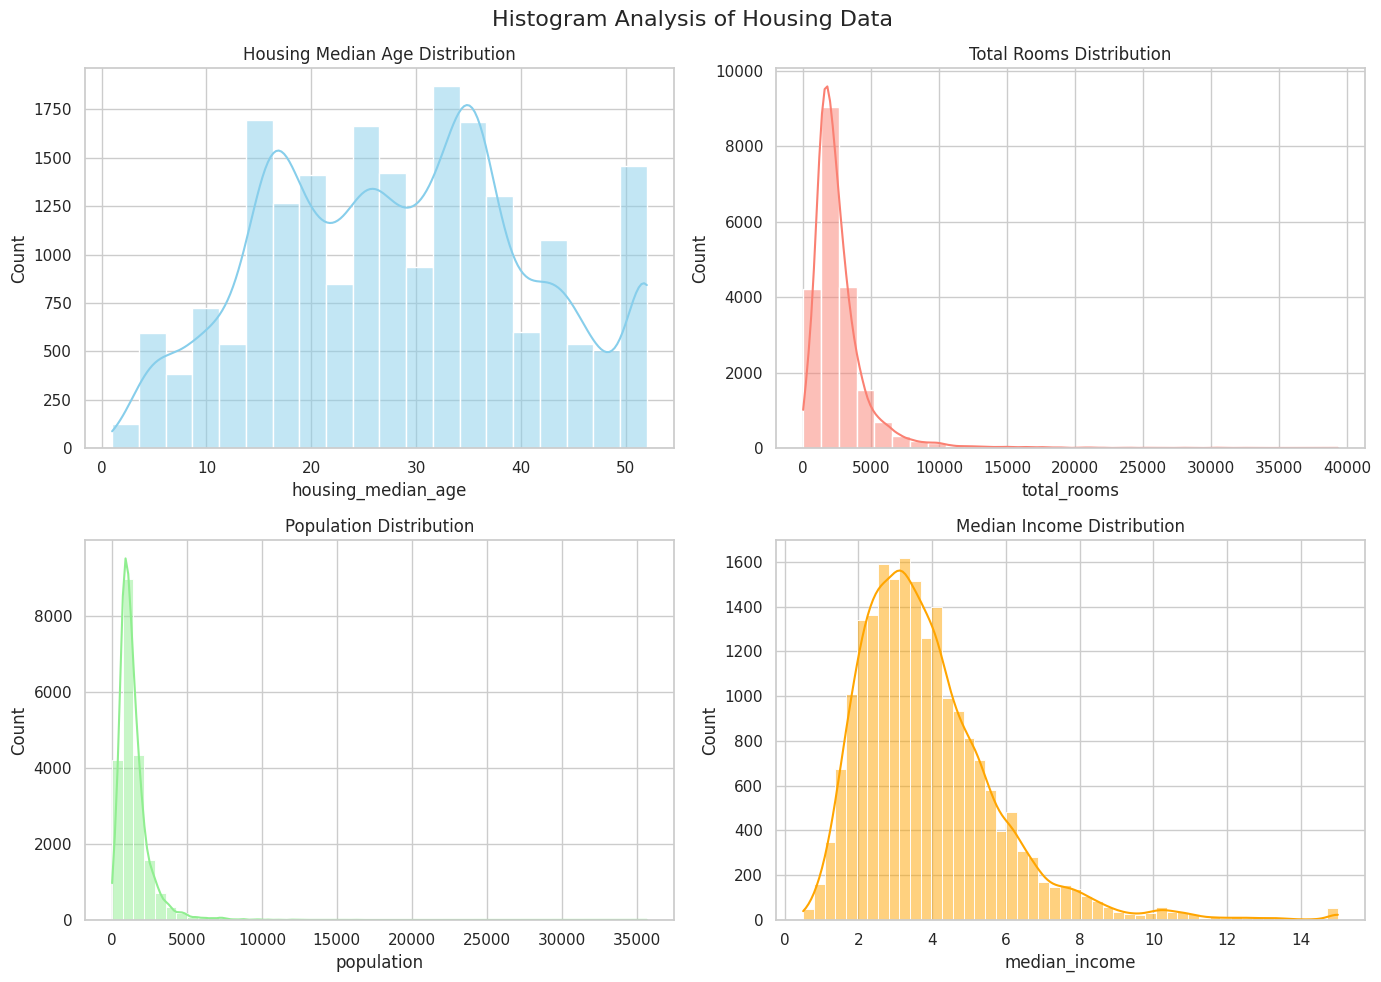

In [45]:
# 2. Setup the figure size
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Histogram Analysis of Housing Data', fontsize=16)

# 3. Plot Histograms for relevant columns from the current dataset

# Housing Median Age
sns.histplot(data=df, x='housing_median_age', kde=True, bins=20, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Housing Median Age Distribution')

# Total Rooms
sns.histplot(data=df, x='total_rooms', kde=True, bins=30, color='salmon', ax=axes[0, 1])
axes[0, 1].set_title('Total Rooms Distribution')

# Population
sns.histplot(data=df, x='population', kde=True, bins=50, color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title('Population Distribution')

# Median Income
sns.histplot(data=df, x='median_income', kde=True, bins=50, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Median Income Distribution')

plt.tight_layout()
plt.show()

##Feature engineering

In [46]:
# Separate features (X) and target (y)
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

# Define the pipeline for Numeric Features
# 1. Impute missing values with median
# 2. Scale features using StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

# Define the pipeline for Categorical Features
# 1. One-hot encode 'ocean_proximity'
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
])

# Combine into a full preprocessor
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, X.select_dtypes(include=['float64', 'int64']).columns),
    ("cat", cat_pipeline, ["ocean_proximity"]),
])

# Prepare the data
X_prepared = full_pipeline.fit_transform(X)

# Get feature names back for XAI later
num_features = list(X.select_dtypes(include=['float64', 'int64']).columns)
cat_encoder = full_pipeline.named_transformers_['cat']['one_hot']
cat_features = list(cat_encoder.get_feature_names_out(['ocean_proximity']))
feature_names = num_features + cat_features

In [47]:
# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (16512, 13)
Testing shape: (4128, 13)


##Train and evaluate for the model.


In [48]:
models = {
    "SVM": SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1), # Adjusted for regression
    "MLP": MLPRegressor(hidden_layer_sizes=[50, 50], max_iter=500, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [49]:
# Dictionary to store trained models for XAI
trained_models = {}

# Loop to train and evaluate
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"  -> RMSE: {rmse:,.2f}")
    print(f"  -> R2 Score: {r2:.4f}\n")

Training SVM...
  -> RMSE: 93,330.83
  -> R2 Score: 0.3353

Training MLP...
  -> RMSE: 64,501.34
  -> R2 Score: 0.6825

Training Random Forest...
  -> RMSE: 48,975.82
  -> R2 Score: 0.8170

Training Gradient Boosting...
  -> RMSE: 55,878.17
  -> R2 Score: 0.7617



##Apply the XAI

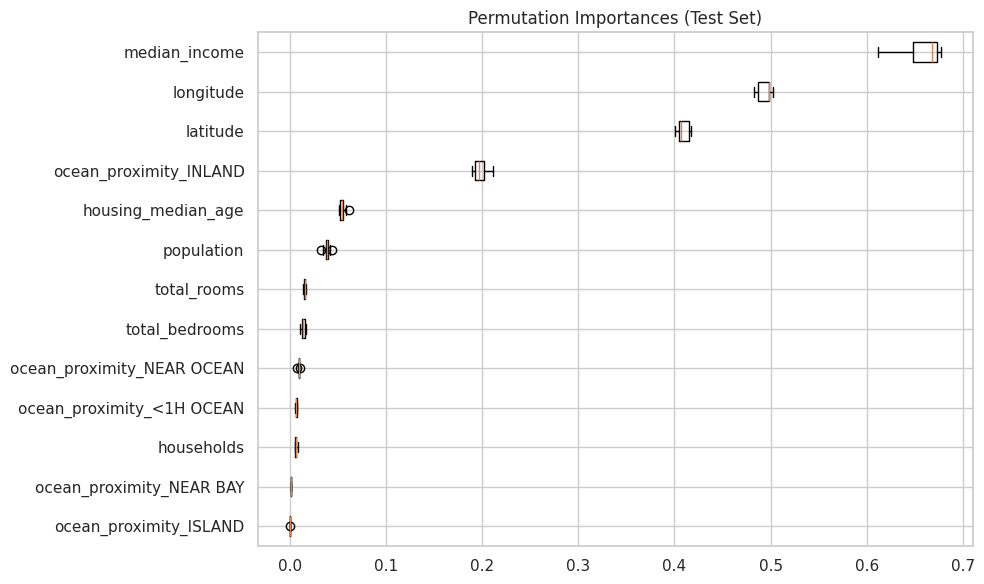

In [50]:
from sklearn.inspection import permutation_importance

# Select the best model (e.g., Random Forest)
best_model = trained_models["Random Forest"]

result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Sort and visualize
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
plt.title("Permutation Importances (Test Set)")
plt.tight_layout()
plt.show()

Generating Partial Dependence Plots...


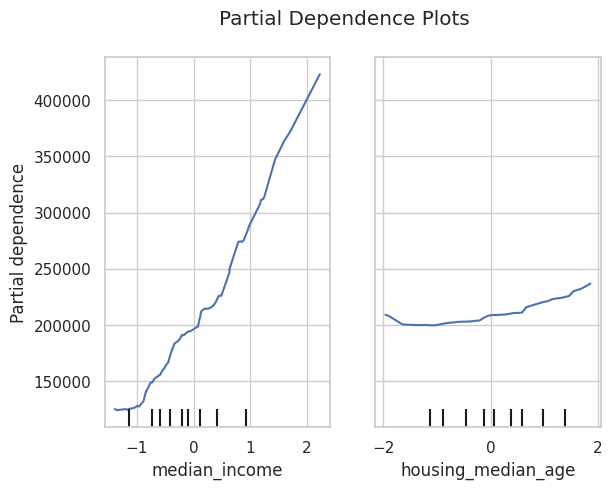

In [51]:
from sklearn.inspection import PartialDependenceDisplay

# Features to analyze (e.g., Median Income and House Age)
features_to_plot = ['median_income', 'housing_median_age', ('median_income', 'housing_median_age')]
# Note: We need the indices of these features in the transformed matrix
indices = [feature_names.index(f) if f in feature_names else 0 for f in ['median_income', 'housing_median_age']]

print("Generating Partial Dependence Plots...")
PartialDependenceDisplay.from_estimator(best_model, X_test[:100], [indices[0], indices[1]], feature_names=feature_names)
plt.suptitle("Partial Dependence Plots")
plt.show()

Generating ICE Plots...


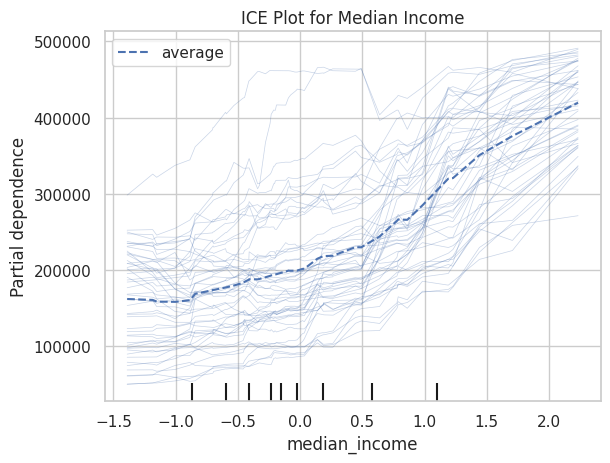

In [52]:
print("Generating ICE Plots...")
# Plot ICE for Median Income
PartialDependenceDisplay.from_estimator(
    best_model,
    X_test[:50],  # Use a subset for clarity
    [indices[0]],
    feature_names=feature_names,
    kind="both"   # 'both' plots individual lines (ICE) and the average (PDP)
)
plt.title("ICE Plot for Median Income")
plt.show()


Actual Value: 158700.0
Predicted Value: 162987.0

LIME Explanation (Feature Contributions):
0.00 < ocean_proximity_INLAND <= 1.00: -82264.59
longitude > 0.78: -46999.65
-0.80 < latitude <= -0.64: 32163.98
population > 0.27: -15376.77
housing_median_age <= -0.85: -9558.75


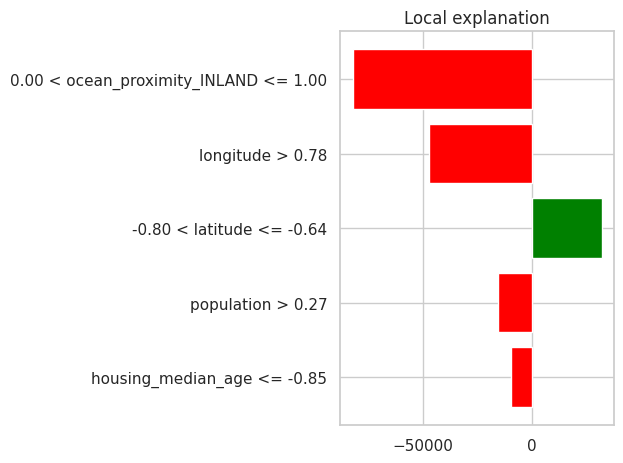

In [53]:
# You may need to install lime: !pip install lime
import lime
import lime.lime_tabular

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['median_house_value'],
    mode='regression'
)

# Pick a specific instance to explain (e.g., the 5th test instance)
i = 5
exp = explainer.explain_instance(X_test[i], best_model.predict, num_features=5)

# Show the explanation
# In a notebook, you would use exp.show_in_notebook(show_table=True)
print(f"\nActual Value: {y_test.iloc[i]}")
print(f"Predicted Value: {best_model.predict(X_test[i].reshape(1, -1))[0]}")
print("\nLIME Explanation (Feature Contributions):")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.2f}")

# To visualize
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

#Dataset 3 : SMS Spam Collection Dataset

In [54]:
print("\nDownloading Dataset 3 :")
!mkdir -p dataset_3
!kaggle datasets download -d uciml/sms-spam-collection-dataset -p dataset_3


Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 729MB/s]


In [55]:
!unzip -q dataset_3/sms-spam-collection-dataset.zip -d dataset_3
!rm dataset_3/sms-spam-collection-dataset.zip
print("Dataset 3 ready in folder: dataset_3/")

Dataset 3 ready in folder: dataset_3/


## Analyze dataset

In [56]:
df = pd.read_csv('dataset_3/spam.csv', encoding='latin1')

In [57]:
df.shape

(5572, 5)

In [58]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [59]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [61]:
df.duplicated().sum()

np.int64(403)

In [62]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols

Index([], dtype='object')

In [63]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [64]:
df[categorical_cols].describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


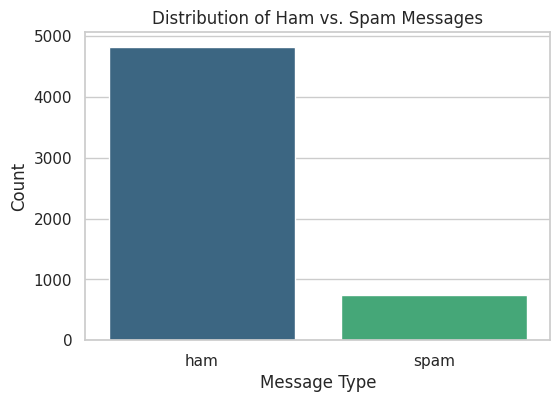

In [65]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='v1', palette='viridis')
plt.title('Distribution of Ham vs. Spam Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

In [66]:
# 3. Duplicates
print(f"\nDuplicates: {df.duplicated().sum()}")
df = df.drop_duplicates(keep='first') # Important for text data
print(f"New Shape after dropping duplicates: {df.shape}")

# 4. Target Distribution
print("\nClass Distribution:")
print(df['v1'].value_counts()) # Changed 'label' to 'v1'

# 5. Feature Engineering for Analysis (Meta-features)
df['length'] = df['v2'].apply(len) # Changed 'message' to 'v2'


Duplicates: 403
New Shape after dropping duplicates: (5169, 5)

Class Distribution:
v1
ham     4516
spam     653
Name: count, dtype: int64


##Feature engineering

In [67]:
# 1. Encode Target (Ham=0, Spam=1)
le = LabelEncoder()
y = le.fit_transform(df['v1'])

# 2. Split Data
X_raw = df['v2']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# 3. Vectorization (The Feature Engineering Step)
# We limit to top 3000 words to keep models fast and interpretable
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)

X_train = tfidf.fit_transform(X_train_raw).toarray()
X_test = tfidf.transform(X_test_raw).toarray()

feature_names = tfidf.get_feature_names_out()

print(f"Training Matrix Shape: {X_train.shape}")

Training Matrix Shape: (4135, 3000)


## Train and evaluate for the model.

In [68]:


# Initialize Models
models = {
    "SVM": SVC(kernel='linear', probability=True, random_state=42), # Linear kernel is often best for text
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

In [69]:


trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"  -> Accuracy: {acc:.4f}")

Training SVM...
  -> Accuracy: 0.9845
Training MLP...
  -> Accuracy: 0.9807
Training Random Forest...
  -> Accuracy: 0.9807
Training Gradient Boosting...
  -> Accuracy: 0.9632


## Apply the XAI

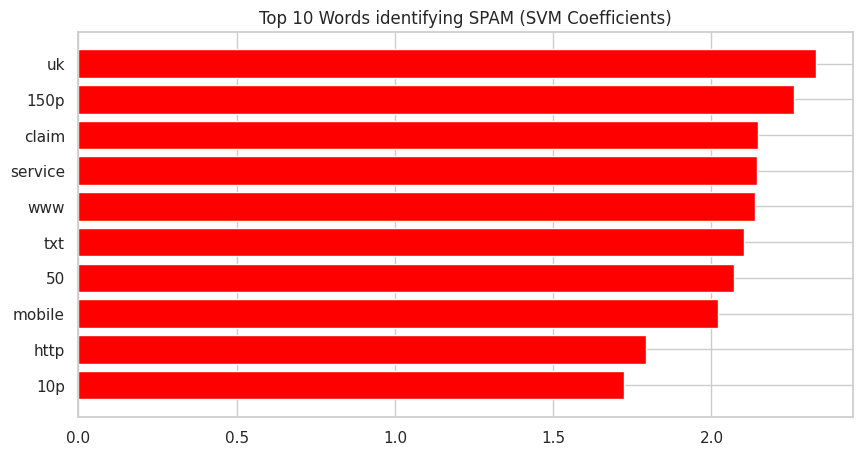

In [70]:
# SVM Coefficients (Linear Kernel) allow direct interpretation
if "SVM" in trained_models:
    coefs = trained_models["SVM"].coef_.flatten()

    # Sort by importance
    top_positive = np.argsort(coefs)[-10:] # Most Spam-like words

    plt.figure(figsize=(10, 5))
    colors = ['red' if coefs[i] > 0 else 'blue' for i in top_positive]
    plt.barh([feature_names[i] for i in top_positive], coefs[top_positive], color=colors)
    plt.title("Top 10 Words identifying SPAM (SVM Coefficients)")
    plt.show()


--- Starting LIME Analysis ---
Message Index: 5
Message Content: URGENT! Your Mobile No was awarded a å£2,000 Bonus Caller Prize on 1/08/03! This is our 2nd attempt to contact YOU! Call 0871-4719-523 BOX95QU BT National Rate
Actual Label: spam

LIME Explanation (Word Contributions):
Mobile         : 0.0595
URGENT         : 0.0521
Rate           : 0.0515
Prize          : 0.0400
National       : 0.0312
awarded        : 0.0237


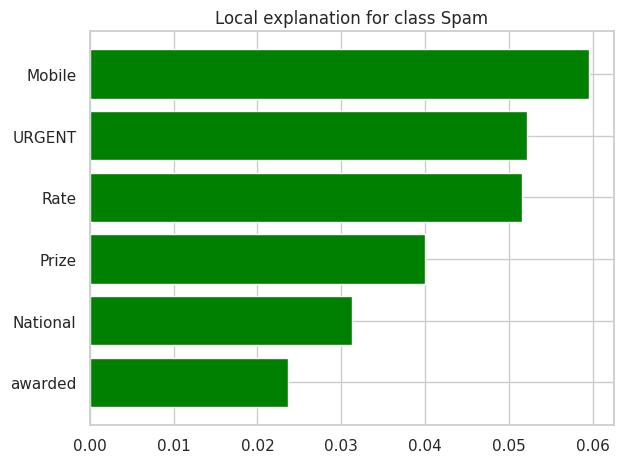

In [82]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

print("\n--- Starting LIME Analysis ---")

# 1. Select the Best Model
# We use SVM because you set probability=True, which LIME requires.
best_model = trained_models["SVM"]

# 2. Create the Pipeline
# This is crucial: LIME generates raw text. We need a pipeline that:
# Raw Text -> TFIDF -> Dense Array -> SVM Prediction
def predict_proba_fn(texts):
    # Transform text to vector
    features = tfidf.transform(texts)
    # Convert to dense array (because you trained the model on dense arrays)
    features_dense = features.toarray()
    return best_model.predict_proba(features_dense)

# 3. Initialize Explainer
explainer = LimeTextExplainer(class_names=['Ham', 'Spam'])

# 4. Pick a specific SPAM message to explain
# We use 'y_test' to find a spam index, but we grab the text from 'X_test_raw'
spam_indices = np.where(y_test == 1)[0]
idx = spam_indices[0] # Pick the first spam message in the test set

# Get the actual raw text string
text_instance = X_test_raw.iloc[idx]
true_label = le.inverse_transform([y_test[idx]])[0]

print(f"Message Index: {idx}")
print(f"Message Content: {text_instance}")
print(f"Actual Label: {true_label}")

# 5. Generate Explanation
# We pass the raw text and our custom prediction function
exp = explainer.explain_instance(
    text_instance,
    predict_proba_fn,
    num_features=6
)

# 6. Visualize Results
print("\nLIME Explanation (Word Contributions):")
# Positive values = Contributes to SPAM, Negative = Contributes to HAM
for word, weight in exp.as_list():
    print(f"{word:<15}: {weight:.4f}")

# Show Plot

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

#Dataset 4 : Face Mask Detection

In [84]:
!pip install kagglehub
import kagglehub
import os
path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")

100%|██████████| 330M/330M [00:03<00:00, 110MB/s]

Extracting files...


In [85]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1


In [92]:
dataset_path = os.path.join(path, 'Face Mask Dataset')
IMG_SIZE = 64
categories = ['WithoutMask', 'WithMask']

In [93]:
print("--- Loading Training Data ---")
train_path = os.path.join(dataset_path, 'Train')
X_train_data = []
y_train_data = []

if os.path.exists(train_path):
    for label_int, category in enumerate(categories):
        folder_path = os.path.join(train_path, category)
        # Limit to first 1000 per class for speed if needed, or load all
        for img_name in os.listdir(folder_path):
            try:
                img_path = os.path.join(folder_path, img_name)
                img_array = cv2.imread(img_path)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                X_train_data.append(new_array)
                y_train_data.append(label_int)
            except Exception as e:
                pass
else:
    print("Train folder not found!")

X_train = np.array(X_train_data)
y_train = np.array(y_train_data)
print(f"Training loaded: {X_train.shape}")

--- Loading Training Data ---
Training loaded: (10000, 64, 64, 3)


In [94]:
print("--- Loading Test Data ---")
test_path = os.path.join(dataset_path, 'Test')
X_test_data = []
y_test_data = []

if os.path.exists(test_path):
    for label_int, category in enumerate(categories):
        folder_path = os.path.join(test_path, category)
        for img_name in os.listdir(folder_path):
            try:
                img_path = os.path.join(folder_path, img_name)
                img_array = cv2.imread(img_path)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                X_test_data.append(new_array)
                y_test_data.append(label_int)
            except Exception as e:
                pass
else:
    print("Test folder not found!")

X_test = np.array(X_test_data)
y_test = np.array(y_test_data)
print(f"Testing loaded: {X_test.shape}")

--- Loading Test Data ---
Testing loaded: (992, 64, 64, 3)


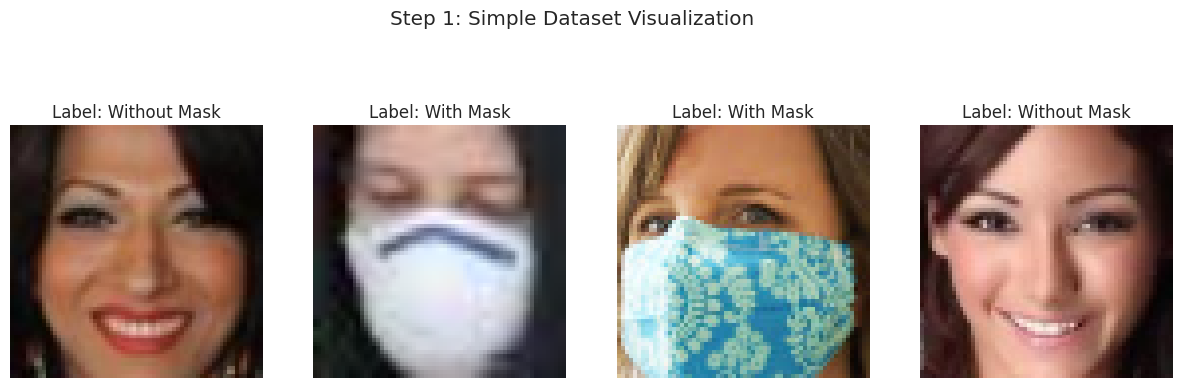

In [106]:
# Show simple samples
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    idx = np.random.randint(0, len(X_train_data))
    axes[i].imshow(X_train_data[idx])
    axes[i].set_title(f"Label: {'With Mask' if y_train[idx] == 1 else 'Without Mask'}")
    axes[i].axis('off')
plt.suptitle("Step 1: Simple Dataset Visualization")
plt.show()

##Feature engineering

In [95]:
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

# Flatten for MLP (N, 64, 64, 3) -> (N, 12288)
X_train_flat = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_test_flat = X_test_norm.reshape(X_test_norm.shape[0], -1)


## Train and evaluate for the model.

In [96]:
print("\n--- Training MLP ---")
# Using MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=15,
    random_state=42,
    verbose=True
)

mlp.fit(X_train_flat, y_train)


--- Training MLP ---
Iteration 1, loss = 0.64259951
Iteration 2, loss = 0.28549060
Iteration 3, loss = 0.20804674
Iteration 4, loss = 0.16259965
Iteration 5, loss = 0.13298049
Iteration 6, loss = 0.13484141
Iteration 7, loss = 0.12303302
Iteration 8, loss = 0.09705762
Iteration 9, loss = 0.08652227
Iteration 10, loss = 0.08503435
Iteration 11, loss = 0.08916859
Iteration 12, loss = 0.07638595
Iteration 13, loss = 0.06665846
Iteration 14, loss = 0.06618537
Iteration 15, loss = 0.07244517


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=15, random_state=42,
              verbose=True)


--- Evaluation ---
Accuracy: 96.07%
              precision    recall  f1-score   support

 WithoutMask       0.95      0.97      0.96       509
    WithMask       0.97      0.95      0.96       483

    accuracy                           0.96       992
   macro avg       0.96      0.96      0.96       992
weighted avg       0.96      0.96      0.96       992



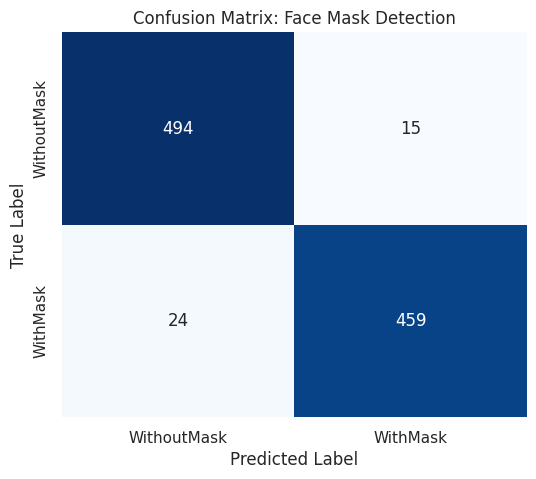

In [100]:
print("\n--- Evaluation ---")
y_pred = mlp.predict(X_test_flat)

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=categories))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5)) # Slightly larger figure
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix: Face Mask Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Apply the XAI (LIME)


--- LIME Explanation ---
Explaining image index: 117


  0%|          | 0/1000 [00:00<?, ?it/s]

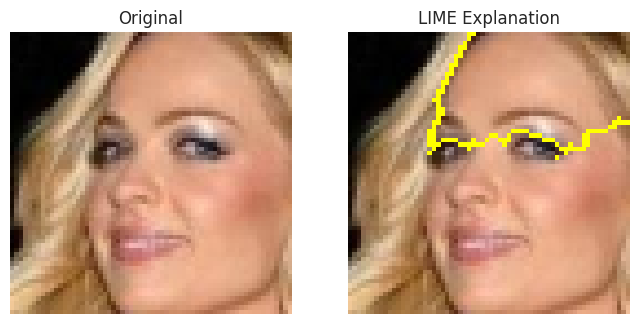

In [104]:
from skimage.segmentation import mark_boundaries

print("\n--- LIME Explanation ---")

# Initialize Explainer
explainer = lime_image.LimeImageExplainer()

# Select random image
idx = np.random.randint(0, len(X_test_norm))
img_to_explain = X_test_norm[idx]
print(f"Explaining image index: {idx}")

# LIME requires a function to predict. We use a lambda (anonymous function)
# to reshape the (N, 64, 64, 3) input from LIME back into (N, 12288) for the MLP
explanation = explainer.explain_instance(
    image=img_to_explain.astype('double'),
    classifier_fn=lambda x: mlp.predict_proba(x.reshape(x.shape[0], -1)),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Visualize
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_to_explain)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()